In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../plotMithraPy')
import plotMiFuncs as pmf
import numpy as np
# To make plot backgrounds white
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
import pandas as pd
import os 
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/pyOPALTools')
from opal.parser.H5Parser import H5Parser
from decimal import Decimal
from scipy.signal import find_peaks

########################
for_report = False
prefixes = [
#    'tests/case1/',
    'tests/caseLowQ/',
    'tests/caseMediumQ/',
    '../full_tests/tests/case6/',
    '../full_tests/tests/case7/',
]

# prefixes.reverse()
generic_fn = 'fullBeamline'
leg = ['6cavities low Q', '6 cavities medium Q', '4 cavities, case1','4 cavities, case2']
fs = 14
########################

if not for_report:
    from datetime import date
    today = date.today()
    footnote = 'A.Albà, ' + str(today) + '\ndir: /' + (os.path.split(os.getcwd()))[1]
#     footnote = 'A.Albà, ' + str(today)
    print(footnote)
    generic_title = 'Linacs with intial modulation'
else:
    generic_title = " "
    footnote = " "
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
A.Albà, 2020-05-11
dir: /full_6cavs


# Functions

In [19]:
def reduceX(x, redF):
    d = []
    for i in range(len(x)):
        if np.random.rand() > 1 / redF:
            d.append(i)
    x = np.delete(x, d)
    return [x,d]

def get_screen_xy( fn_prefix, screen_name, qx, qy, show = False, reduce_factor = 1 ):    
    ''' Get data to plot from file fn and given screen. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] '''
    fn = fn_prefix + screen_name
    h5p = H5Parser()
    step = 0
    h5p.parse( fn, False )
    if show:
        print(h5p)
    if qx == 't':
        qx = 'time'
    if qy == 't':
        qy = 'time'
    x = h5p.getStepDataset( dsetName = qx, step = step)
    [x,delInd] = reduceX(x,reduce_factor)
    if qy == 'E':
        # Get E
        E = []
        px = h5p.getStepDataset( dsetName = 'px', step = step)
        px = np.delete(px,delInd)
        py = h5p.getStepDataset( dsetName = 'py', step = step)
        py = np.delete(py,delInd)
        pz = h5p.getStepDataset( dsetName = 'pz', step = step)
        pz = np.delete(pz,delInd)
        for i, pxi in enumerate(px):
            p2 = px[i]**2 + py[i]**2 + pz[i]**2  
            E.append( np.sqrt( 1 + p2 )*.511 )
        y = np.array(E) * 1e6
    else:
        y = h5p.getStepDataset( dsetName = qy, step = step)
        y = np.delete(y,delInd)
            
    spos = h5p.getStepAttribute('SPOS', step = step)
    print('spos = ',spos)

    
    return [ np.array(x), np.array(y), spos[0] ]


def adjust_axes_limits( axs, axis = 'x' ):
    '''
    Adjusts all axis ranges to the one with the biggest range
    axs : (list or array af matplotlib axes)
    axis : (string) Indicates whether to adjust x or y axis
    '''
    crange = []
    for ax in axs:
        if axis == 'x':
            crange.append( np.ptp(ax.get_xlim()) )
        elif axis == 'y':
            crange.append( np.ptp(ax.get_ylim()) )

    def change_limits( ax, r, axis = 'x' ):
        if axis == 'x':
            ax.set_xlim( ax.get_xlim()[0] - r/2., ax.get_xlim()[1] + r/2.)
        elif axis == 'y':
            ax.set_ylim( ax.get_ylim()[0] - r/2., ax.get_ylim()[1] + r/2.)

    r = np.max(crange)
    for i, ax in enumerate(axs):
        change_limits( ax, r - crange[i], axis = axis  )

In [20]:
def getStats(fn, show = False):
    print(fn)
    text = open( fn, 'r' )
    names = []
    units = []
    for line in text:
        if 'name' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            name = line[ind1+1:ind2]
        if 'units' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            unit = line[ind1+1:ind2]
            if unit == '1':
                unit = ' '
            names.append( name )
            units.append( unit )
    if show:
        for i, n in enumerate(names):        
            print( i, n, ' [', units[i], ']' )
    stat = pd.read_csv( filepath_or_buffer = fn,
                        skiprows = 279, sep = '\s+', names = names)
    return[stat, names, units]

# Plot stats

In [5]:
fn = prefixes[1] + generic_fn + '.stat'
[stat, names, units] = getStats(fn, show = False)

tests/caseMediumQ/fullBeamline.stat


value of dE [MeV] at [25.8] are [0.33560672]
value of rms_x [m] at [25.8] is [0.00034361]


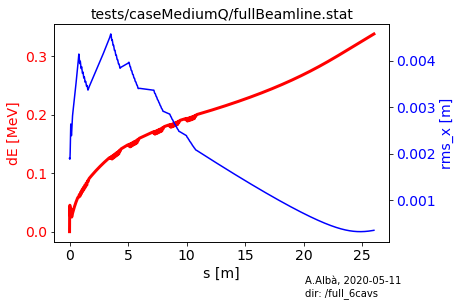

In [6]:
################################
xax = 1
ylax = 39
yrax = 5  # -1 to plot only one quantity
colorL = 'r'
colorR = 'b'
getValuesAt = [25.8]
################################
x = np.array( stat[names[xax]] )
labxax = str( names[xax] + ' [' + units[xax] + ']')

y = np.array( stat[names[ylax]] )
labyax = str( names[ylax] + ' [' + units[ylax] + ']')
# if 'emit' in labyax:
#     y = np.log(y)
#     labyax = 'log ' + labyax

fig, ax1 = plt.subplots()
if 'emit' in labyax:
    ax1.semilogy(x, y, color = colorL, lw = 2)
else:
    ax1.plot( x, y, color = colorL, lw = 3 )
# ax1.plot( x, np.array(stat[names[ylax+1]]), color = 'k' )
# ax1.legend(['rms_x', 'rms_y'], fontsize = fs)
ax1.set_xlabel(labxax, fontsize = fs)
ax1.set_ylabel(labyax, fontsize = fs, color = colorL)
ax1.tick_params( axis = 'y', labelsize = fs, labelcolor = colorL )
ax1.tick_params( axis = 'x', labelsize = fs, labelcolor = 'k')
if len(getValuesAt) > 0:
    print( 'value of', labyax, 'at', getValuesAt, 'are', np.interp(getValuesAt, x, y) )


plt.text( .75, -.25, footnote, transform=ax1.transAxes )
plt.title(fn, fontsize = fs)
# ax1.grid()
# ax1.set_xlim( left = 0.0, right = 2 )
# ax1.set_ylim( bottom = 0.0, top = 14e-3 )

if yrax != -1:
    y = np.array( stat[names[yrax]] )
    labyax = str( names[yrax] + ' [' + units[yrax] + ']')
    if 'emit' in labyax:
        y = np.log(y)
        labyax = 'log ' + labyax
    ax2 = ax1.twinx()
    ax2.plot( x, y, color = colorR )
    ax2.set_ylabel(labyax, fontsize = fs, color = colorR)
    ax2.tick_params( axis = 'y', labelsize = fs, labelcolor = colorR )
    # ax2.set_ylim( bottom = .0, top = .04 )
    # ax2.grid()
    if len(getValuesAt) > 0:
        print( 'value of', labyax, 'at', getValuesAt, 'is', np.interp(getValuesAt, x, y) )
        # ax1.axvline(getValuesAt[0])

# ax1.annotate('$\epsilon_x = 7.45$ mm mrad', xy = (25.8, 7.45e-6),
#              xytext = (12,1e-4), arrowprops=dict(facecolor='black', shrink=1e-9), fontsize = fs)
# ax2.annotate('$\sigma_x = 1.25$ mm', xy = (25.8, 1.25e-3),
#              xytext = (12,3.25e-3), arrowprops=dict(facecolor='black', shrink=1e-9), fontsize = fs)
plt.savefig('plots/rms_6cavs_medium.png', bbox_inches='tight')
plt.show()

tests/case2/fullBeamline.stat
end y value =  3.379798053522238e-06
../full_tests/tests/case6/fullBeamline.stat


end y value =  4.89209020759107e-06
../full_tests/tests/case7/fullBeamline.stat
end y value =  3.5839319214535033e-06


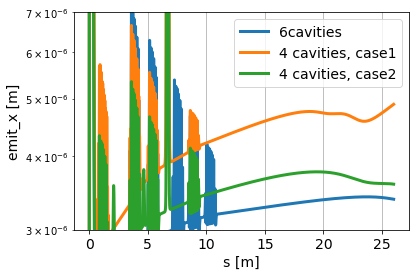

In [15]:
xax = 1
yax = 11
fig, ax = plt.subplots()

for pref in prefixes:
    [stat, names, units] = getStats(pref + generic_fn + '.stat', show = False)
    x = np.array( stat[names[xax]] )
    labxax = str( names[xax] + ' [' + units[xax] + ']')
    y = np.array( stat[names[yax]] )
    labyax = str( names[yax] + ' [' + units[yax] + ']')
    # ax.plot( x, y, lw = 3 )
    ax.semilogy( x, y, lw = 3 )
    print('end y value = ', y[-1])

ax.set_ylim(bottom = 3e-6, top = 7e-6)
ax.set_xlabel(labxax, fontsize = fs)
ax.set_ylabel(labyax, fontsize = fs)
ax.tick_params( axis = 'both', labelsize = fs)

ax.legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
ax.grid()
plt.savefig('plots/all_epsN_zoom.png', bbox_inches='tight')
plt.show()
    

# Phase Space

spos =  [25.27]


spos =  [25.27]


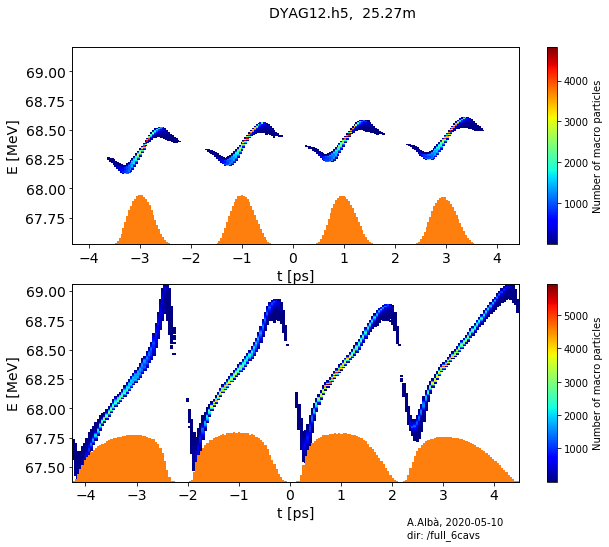

In [8]:
# Plot screens
screenFile = 'DYAG12.h5'
qx = 't'
qy = 'E'

locPrefixes = prefixes
locPrefixes = locPrefixes[:2]

fig, ax = plt.subplots(len(locPrefixes))
fig.set_size_inches(10, 4 * len(locPrefixes))
for i, p in enumerate(locPrefixes):
    [x,y,spos] = get_screen_xy(p, screenFile, qx, qy, show = False, reduce_factor = 1)
    pmf.plotScreenXY(ax[i], x, y, [qx, qy], type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 200, color = 1, maxHH = .25)
    pmf.adjust_axes_limits( ax, 'x' )
    pmf.adjust_axes_limits( ax, 'y' )
ax[-1].text( .75, -.28, footnote, transform=ax[-1].transAxes )
fig.suptitle(screenFile + ',  ' + "{:.2f}".format(spos) + 'm' , fontsize = fs, y = .95)

plt.savefig('plots/medium.png', bbox_inches='tight')
plt.show()


tests/caseLowQ//bunch-sampling/bunch.txt
tests/caseMediumQ//bunch-sampling/bunch.txt
../full_tests/tests/case6//bunch-sampling/bunch.txt
../full_tests/tests/case7//bunch-sampling/bunch.txt


Mesh limits z -0.03655492118913735 0.03655492118913735
Mesh limits x -0.007 0.007
Mesh limits y -0.007 0.007


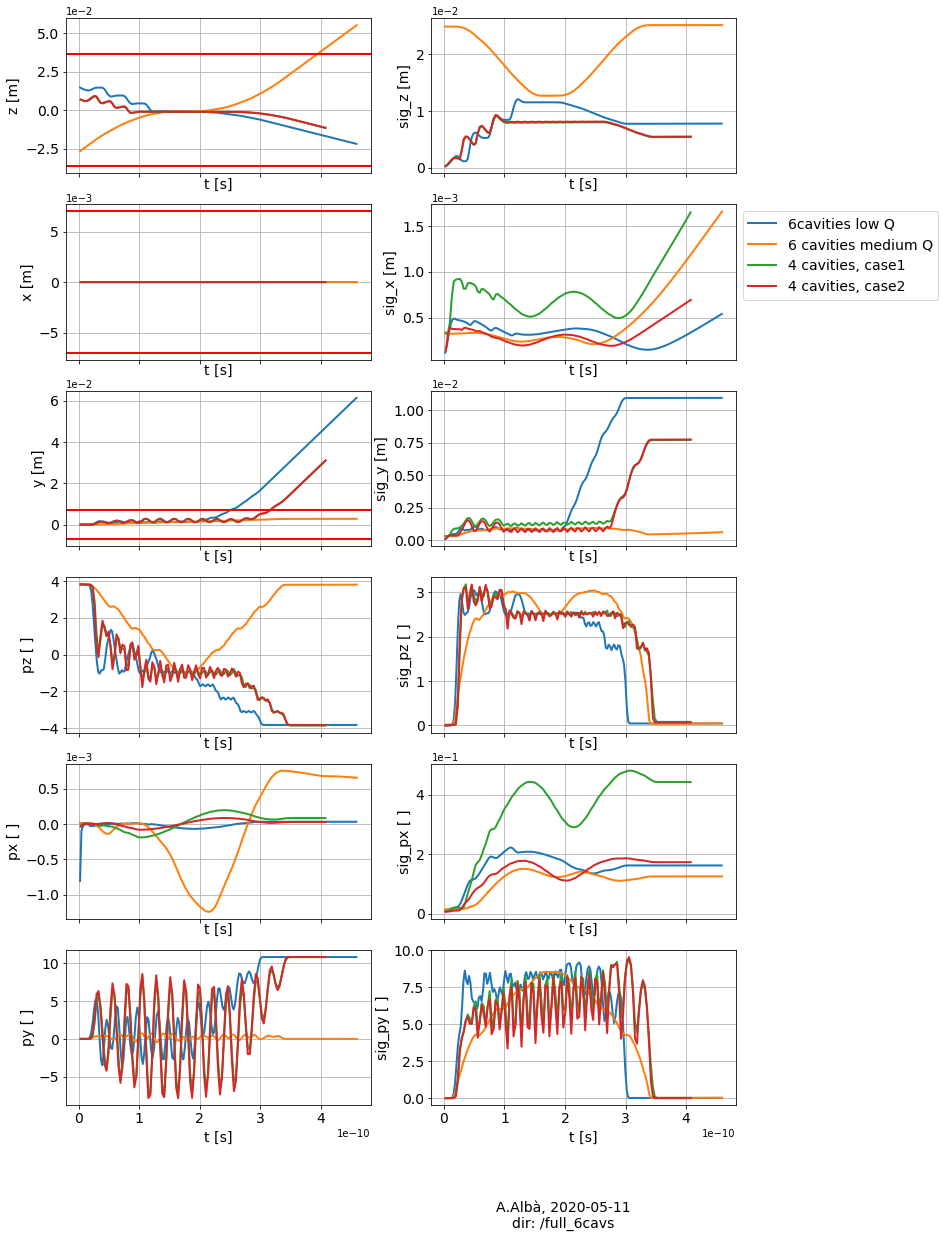

In [16]:
# Stats undulator
stats = []
for p in prefixes:
    stats.append( pmf.importStat( p + '/bunch-sampling/bunch.txt', show = True) )

names = [ 'z', 'sig_z', 'x', 'sig_x', 'y', 'sig_y',
             'pz', 'sig_pz', 'px', 'sig_px', 'py', 'sig_py']

fig, axs = plt.subplots( 6,2, figsize = ( 12, 20 ), sharex = True )
Ls = [14e-3, 14e-3, 6e-3]  # Mesh lengths
K = 10.81
E = 48  # MeV
Ls[2] *= E / .511 / np.sqrt(1 + .5 * K**2)  # * gamma_
dotted = [4,5]  # Indexes from fnames to plot with dotted lines
notPlot = []  # Indexes from fnames not to plot
legLocal = []
for i, ax in enumerate(axs.reshape(-1)):
    ax.grid()
    for j, stat in enumerate(stats):
        if j in notPlot:
            continue
        if j in dotted:
            ls = ':'
            lw = 3
        else:
            ls = '-'
            lw = 2
        pmf.plotStat(ax, stat, quants = ['t',names[i]], factors = [1, 1], fs = fs, lw = lw, ls = ls )
        # legLocal.append(leg[j])
        # if int(i/10) == 0:
        #     ax.set_xlabel('')
        axs[1,1].legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
# Draw mesh limits
xyz = ['x', 'y', 'z']
for j in range(3):
    i  = (2 + j) % 3
    print('Mesh limits', xyz[i], -.5 * Ls[i], .5 * Ls[i])
    axs[j,0].axhline(-.5 * Ls[i], lw = 2, color = 'r')
    axs[j,0].axhline(.5 * Ls[i], lw = 2, color = 'r')
    # axs[j,0].set_ylim(bottom = -.5 * Ls[i], top = .5 * Ls[i])  # Mesh limits as plot limits
if not for_report:
    fig.text(.7, .04, footnote, fontsize = fs, ha='center')
# plt.savefig((pltpath + '/avg.png'),bbox_inches='tight')
plt.show()

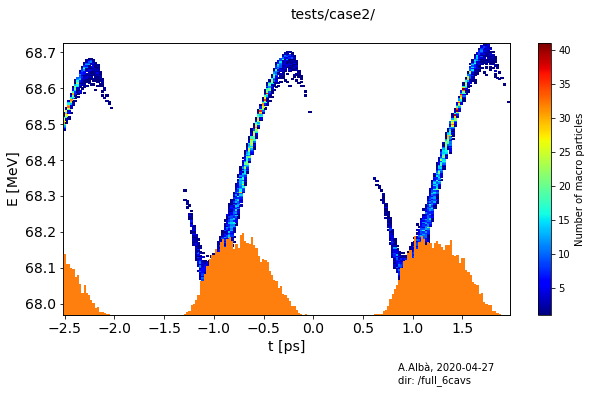

In [11]:
fn = prefixes[-1]
xquant = 't'
yquant = 'E'
rf = 100
fig, ax = plt.subplots(1,1,figsize = (10, 5))
[x,y] = pmf.importScreenXY( fn + 'bunch-screen/bunch-p#-screen#.txt', show = False, xquant = xquant, yquant = yquant, index_screen = -1, reduce_factor = rf)
pmf.plotScreenXY(ax, x, y, [xquant, yquant], type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 200, color = 1)
# ax.text( 1.3, .4, 'After wiggler', transform=axs[1].transAxes, fontsize = fs, ha='center' )
fig.suptitle(fn, fontsize = fs)
ax.text( .75, -.25, footnote, transform=ax.transAxes )
# pmf.adjust_axes_limits( axs, 'x' )
# pmf.adjust_axes_limits( axs, 'y' )
# plt.savefig( ('plots' + '/befAft.png'), bbox_inches='tight' )    
plt.show()

spos =  [25.27]


3000000 particles has been reduced to 29879
Using 29879 particles for the plots


spos =  [25.27]


1999969 particles has been reduced to 20181
Using 20181 particles for the plots


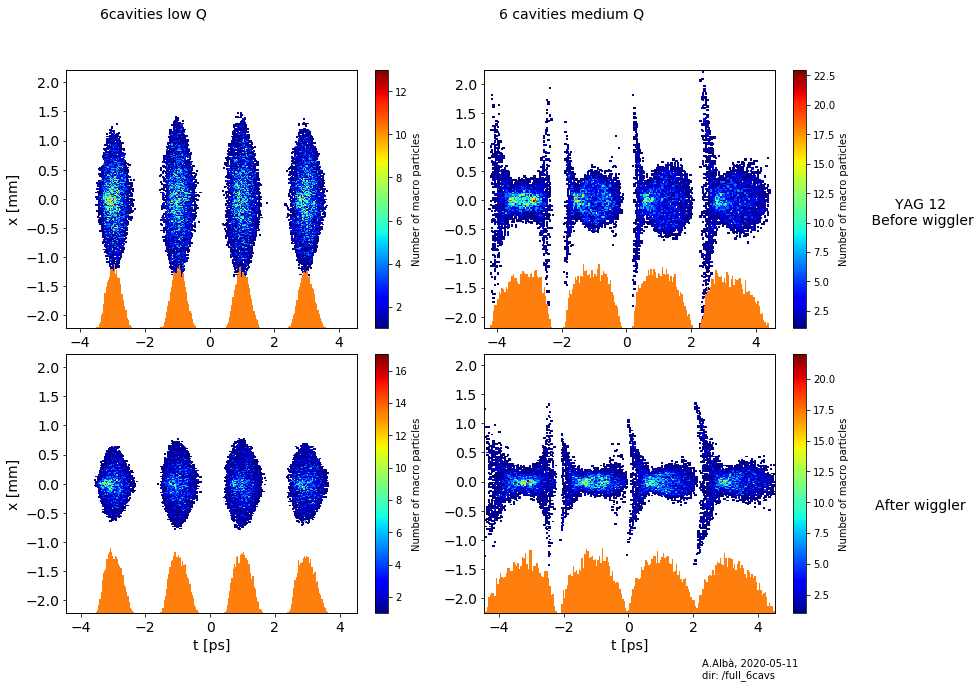

In [23]:
# Plot yag and last screen for all examples
fnYAG = 'DYAG12.h5'
xquant = 't'
yquant = 'x'
ybot = 66
ytop = 70
nbins = 200
rf = 100.0
factors = [-1e12,1e3]
maxHH = .25
locPrefixes = prefixes
locPrefixes = locPrefixes[:2]

fig, ax = plt.subplots(2,len(locPrefixes), figsize = (7 * len(locPrefixes),10), sharex = False, sharey = False)
fig.subplots_adjust(hspace = .1, wspace = .15)
for i,fn in enumerate(locPrefixes):
    # Before und
    [x,y,spos] = get_screen_xy(fn, fnYAG, xquant, yquant, show = False, reduce_factor = rf)
    pmf.plotScreenXY(ax[0,i], x, y, [xquant, yquant], type = 'hist2d-hist', factors = factors, nbins = nbins, color = 1, maxHH = maxHH)
    ax[0,i].set_xlabel('')
    ax[0,i].text(.3, 1.2, leg[i], transform=ax[0,i].transAxes, fontsize = fs, ha='center' )
    # ax[0,i].set_xlim(left = -4.0, right = 4.0)
    # ax[0,i].set_ylim(bottom = ybot, top = ytop)
    # After und
    [x,y] = pmf.importScreenXY( fn + 'bunch-screen/bunch-p#-screen#.txt', show = False, xquant = xquant, yquant = yquant, index_screen = -1, reduce_factor = rf)
    pmf.plotScreenXY(ax[1,i], x, y, [xquant, yquant], type = 'hist2d-hist', factors = factors, nbins = nbins, color = 1, maxHH = maxHH)
    # ax[1,i].set_ylim(bottom = ybot, top = ytop)
    # ax[1,i].set_xlim(left = -4.0, right = 4.0)
    print('Using', len(x), 'particles for the plots')
ax[0,1].set_ylabel('', fontsize = fs)
ax[1,1].set_ylabel('', fontsize = fs)
ax[0,-1].text( 1.5, .4, 'YAG 12\n Before wiggler', transform=ax[0,-1].transAxes, fontsize = fs, ha='center' )
ax[1,-1].text( 1.5, .4, 'After wiggler', transform=ax[1,-1].transAxes, fontsize = fs, ha='center' )
ax[-1,-1].text( .75, -.25, footnote, transform=ax[-1,-1].transAxes )
pmf.adjust_axes_limits(ax.reshape(-1), 'y')
pmf.adjust_axes_limits(ax.reshape(-1), 'x')
plt.savefig( ('plots' + '/S2Eall.png'), bbox_inches='tight' )    
plt.show()

In [ ]:
# fn = prefixes[-1]
# [data, screens] = pmf.importScreen( fn + 'bunch-screen/bunch-p#-screen#.txt', show = True )

columns =  ['q', 'x', 'y', 't', 'px', 'py', 'pz']
Number of screens =  1 , number of processors =  88
0 tests/case5/bunch-screen/bunch-p#-screen0.txt


Screens at  [0.95]


Npart =  100000


Npart =  100000


Npart =  100000


Npart =  100000


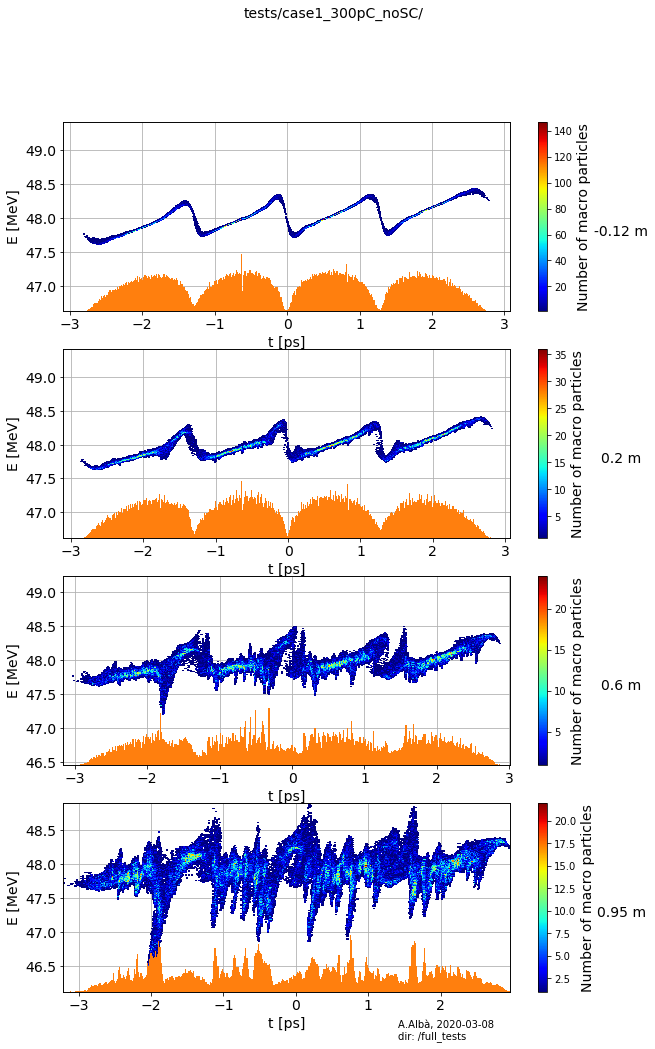

In [13]:
# Plot all screens for one folder
fig, ax = plt.subplots( len(screens), 1, figsize = ( 10, 4*len(screens) ), sharey = False, sharex = False )
if len(screens) > 1:
    ax = ax.reshape(-1)
    for i in range(len(screens)):
        [x,y] = pmf.plotScreen( ax[i], data, ['t', 'E'], screenNum = i, type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 400, color = 1)
        ax[i].text( 1.25, .4, str(screens[i]) + ' m', transform=ax[i].transAxes, fontsize = fs, ha='center' )
        ax[i].grid()
        print('Npart = ', len(x))
        # ax[i].set_xlim(left = 0.5, right = 0.8)
        # ax[i].set_ylim(bottom = -1e-1, top = 1e-1)

    pmf.adjust_axes_limits( ax, 'x' )
    pmf.adjust_axes_limits( ax, 'y' )
else:
    [x,y] = pmf.plotScreen( ax, data, ['x', 'px'], screenNum = 0, type = 'hist2d', factors = [-1e12,1e-6], nbins = 100, color = 1)
 
fig.suptitle(fn, fontsize = fs)
ax[-1].text( .75, -.25, footnote, transform=ax[-1].transAxes )
# plt.savefig( ('plots' + '/energy_case1_300pC_noSC.png'), bbox_inches='tight' )    
plt.show()
